<a href="https://colab.research.google.com/github/nikhilScripts/Image-Segmentation/blob/main/U_Net_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Building U-Net from scratch**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)




Output shape: torch.Size([1, 1, 161, 161])


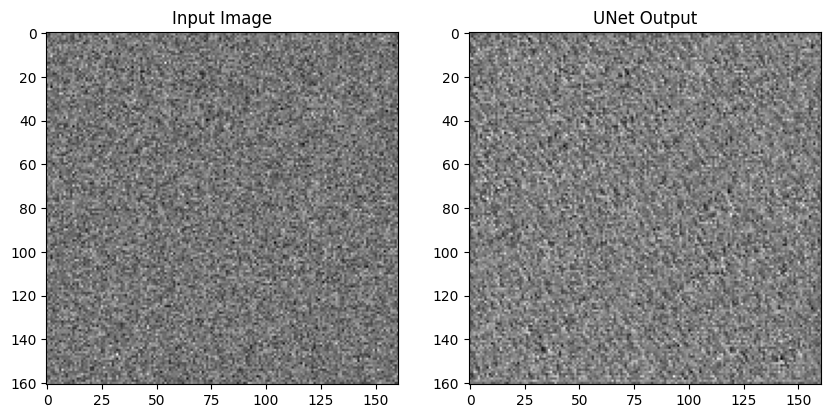

In [ ]:
def test_model():
    x = torch.randn((1, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(f"Output shape: {preds.shape}")
    return x, preds

def plot_results(x, preds):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x[0, 0].detach().numpy(), cmap='gray')
    ax[0].set_title("Input Image")
    ax[1].imshow(preds[0, 0].detach().numpy(), cmap='gray')
    ax[1].set_title("UNet Output")
    plt.show()

if __name__ == "__main__":
    x, preds = test_model()
    plot_results(x, preds)


In [ ]:
# Add this import to the top of your script:
!pip install torchviz

  Using cached torchviz-0.0.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torchviz-0.0.3-py3-none-any.whl (5.7 kB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)


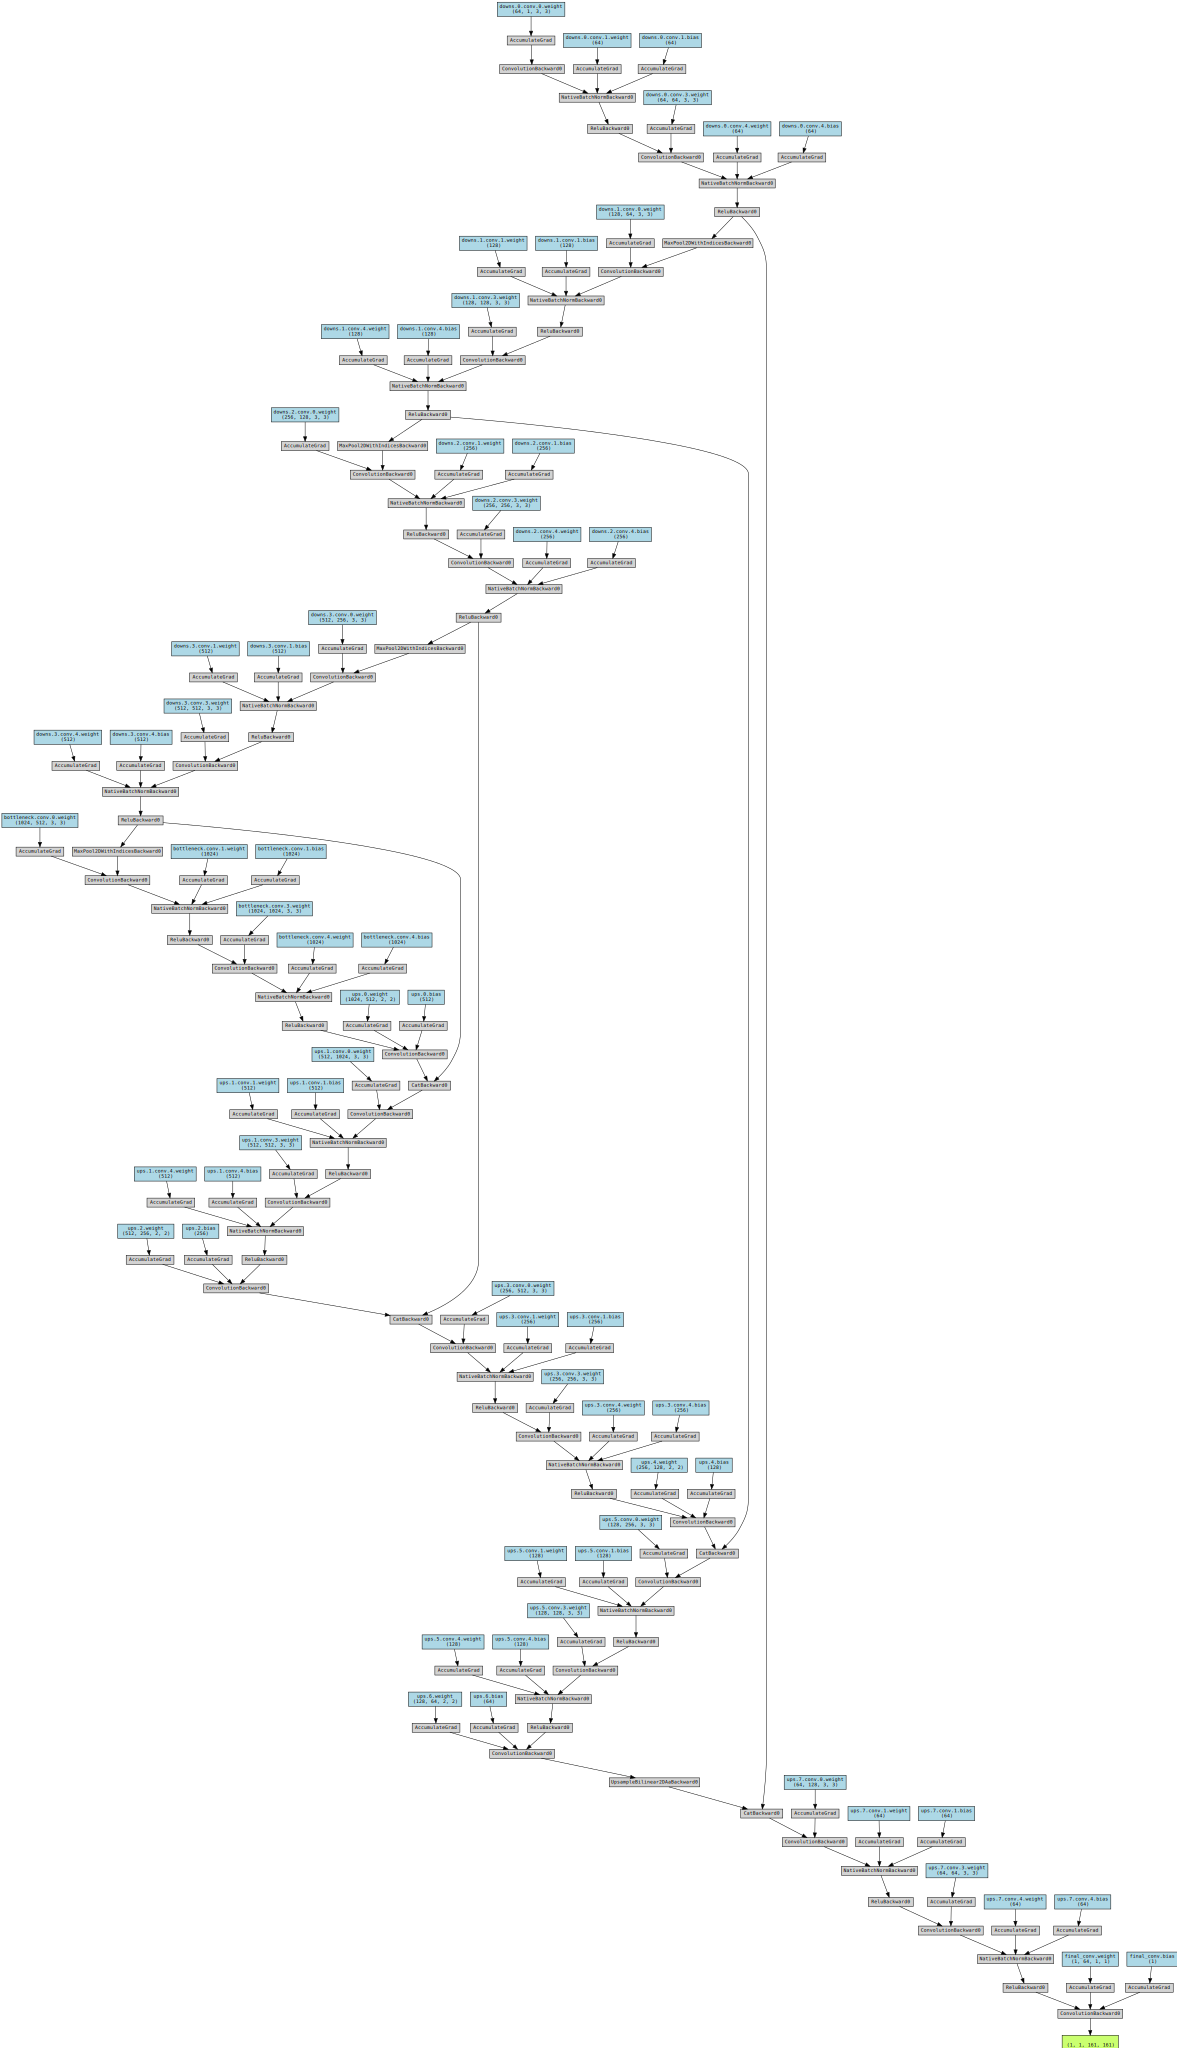

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 161, 161]             576
       BatchNorm2d-2         [-1, 64, 161, 161]             128
              ReLU-3         [-1, 64, 161, 161]               0
            Conv2d-4         [-1, 64, 161, 161]          36,864
       BatchNorm2d-5         [-1, 64, 161, 161]             128
              ReLU-6         [-1, 64, 161, 161]               0
        DoubleConv-7         [-1, 64, 161, 161]               0
         MaxPool2d-8           [-1, 64, 80, 80]               0
            Conv2d-9          [-1, 128, 80, 80]          73,728
      BatchNorm2d-10          [-1, 128, 80, 80]             256
             ReLU-11          [-1, 128, 80, 80]               0
           Conv2d-12          [-1, 128, 80, 80]         147,456
      BatchNorm2d-13          [-1, 128, 80, 80]             256
             ReLU-14          [-1, 128,

In [ ]:
import torchviz

def visualize_model():
    model = UNET(in_channels=1)
    x = torch.randn(1, 1, 161, 161)
    dot = torchviz.make_dot(model(x), params=dict(model.named_parameters()))
    return dot

if __name__ == "__main__":

    from IPython.display import display

    display(visualize_model())
    try:
        from torchsummary import summary
        summary(UNET(in_channels=1), (1, 161, 161))
    except ImportError:
        print("Please install torchsummary: !pip install torchsummary")

## double U-Net

In [ ]:
!kaggle datasets download drscarlat/melanoma

Dataset URL: https://www.kaggle.com/datasets/drscarlat/melanoma
License(s): unknown
100% 5.25G/5.26G [00:33<00:00, 160MB/s]
100% 5.26G/5.26G [00:34<00:00, 166MB/s]


In [ ]:
%%capture
!unzip /content/melanoma.zip -d /content
print("Unzipping completed!")

In [ ]:
# to delete a file forcefully
# !rm -rf /content/dermmel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19

class Conv2D(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, dilation=1, bias=False, act=True):
        super().__init__()
        self.act = act

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_c, out_c,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                bias=bias
            ),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.act == True:
            x = self.relu(x)
        return x


class squeeze_excitation_block(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super().__init__()

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels//ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels//ratio, in_channels),
            nn.Sigmoid()
        )


    def forward(self, x):
        batch_size, channel_size, _, _ = x.size()
        y = self.avgpool(x).view(batch_size, channel_size)
        y = self.fc(y).view(batch_size, channel_size, 1, 1)
        return x*y.expand_as(x)

class ASPP(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            Conv2D(in_c, out_c, kernel_size=1, padding=0)
        )

        self.c1 = Conv2D(in_c, out_c, kernel_size=1, padding=0, dilation=1)
        self.c2 = Conv2D(in_c, out_c, kernel_size=3, padding=6, dilation=6)
        self.c3 = Conv2D(in_c, out_c, kernel_size=3, padding=12, dilation=12)
        self.c4 = Conv2D(in_c, out_c, kernel_size=3, padding=18, dilation=18)

        self.c5 = Conv2D(out_c*5, out_c, kernel_size=1, padding=0, dilation=1)

    def forward(self, x):
        x0 = self.avgpool(x)
        x0 = F.interpolate(x0, size=x.size()[2:], mode="bilinear", align_corners=True)

        x1 = self.c1(x)
        x2 = self.c2(x)
        x3 = self.c3(x)
        x4 = self.c4(x)

        xc = torch.cat([x0, x1, x2, x3, x4], axis=1)
        y = self.c5(xc)

        return y

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.c1 = Conv2D(in_c, out_c)
        self.c2 = Conv2D(out_c, out_c)
        self.a1 = squeeze_excitation_block(out_c)

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.a1(x)
        return x

class encoder1(nn.Module):
    def __init__(self):
        super().__init__()

        network = vgg19(pretrained=True)
        # print(network)

        self.x1 = network.features[:4]
        self.x2 = network.features[4:9]
        self.x3 = network.features[9:18]
        self.x4 = network.features[18:27]
        self.x5 = network.features[27:36]

    def forward(self, x):
        x0 = x
        x1 = self.x1(x0)
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        x4 = self.x4(x3)
        x5 = self.x5(x4)
        return x5, [x4, x3, x2, x1]

class decoder1(nn.Module):
    def __init__(self):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.c1 = conv_block(64+512, 256)
        self.c2 = conv_block(512, 128)
        self.c3 = conv_block(256, 64)
        self.c4 = conv_block(128, 32)

    def forward(self, x, skip):
        s1, s2, s3, s4 = skip

        x = self.up(x)
        x = torch.cat([x, s1], axis=1)
        x = self.c1(x)

        x = self.up(x)
        x = torch.cat([x, s2], axis=1)
        x = self.c2(x)

        x = self.up(x)
        x = torch.cat([x, s3], axis=1)
        x = self.c3(x)

        x = self.up(x)
        x = torch.cat([x, s4], axis=1)
        x = self.c4(x)

        return x

class encoder2(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d((2, 2))

        self.c1 = conv_block(3, 32)
        self.c2 = conv_block(32, 64)
        self.c3 = conv_block(64, 128)
        self.c4 = conv_block(128, 256)

    def forward(self, x):
        x0 = x

        x1 = self.c1(x0)
        p1 = self.pool(x1)

        x2 = self.c2(p1)
        p2 = self.pool(x2)

        x3 = self.c3(p2)
        p3 = self.pool(x3)

        x4 = self.c4(p3)
        p4 = self.pool(x4)

        return p4, [x4, x3, x2, x1]

class decoder2(nn.Module):
    def __init__(self):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.c1 = conv_block(832, 256)
        self.c2 = conv_block(640, 128)
        self.c3 = conv_block(320, 64)
        self.c4 = conv_block(160, 32)

    def forward(self, x, skip1, skip2):

        x = self.up(x)
        x = torch.cat([x, skip1[0], skip2[0]], axis=1)
        x = self.c1(x)

        x = self.up(x)
        x = torch.cat([x, skip1[1], skip2[1]], axis=1)
        x = self.c2(x)

        x = self.up(x)
        x = torch.cat([x, skip1[2], skip2[2]], axis=1)
        x = self.c3(x)

        x = self.up(x)
        x = torch.cat([x, skip1[3], skip2[3]], axis=1)
        x = self.c4(x)

        return x

class build_doubleunet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder1()
        self.a1 = ASPP(512, 64)
        self.d1 = decoder1()
        self.y1 = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

        self.e2 = encoder2()
        self.a2 = ASPP(256, 64)
        self.d2 = decoder2()
        self.y2 = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        x0 = x
        x, skip1 = self.e1(x)
        x = self.a1(x)
        x = self.d1(x, skip1)
        y1 = self.y1(x)

        input_x = x0 * self.sigmoid(y1)
        x, skip2 = self.e2(input_x)
        x = self.a2(x)
        x = self.d2(x, skip1, skip2)
        y2 = self.y2(x)

        return y1, y2

if __name__ == "__main__":
    x = torch.randn((8, 3, 256, 256))
    model = build_doubleunet()
    y1, y2 = model(x)
    print(y1.shape, y2.shape)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


metrics

Utils

Train

In [ ]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


def load_data(path):
    def get_data(path, name):
        images = sorted(glob(os.path.join(path, name, "images")))
        labels = sorted(glob(os.path.join(path, name, "masks", "melanoma")))
        return images, labels

    """ Names """
    dirs = sorted(os.listdir(path))
    test_names = [f"melanoma{i}" for i in range(0, 30, 1)]
    valid_names = [f"melaoma{i}" for i in range(30, 60, 1)]

    train_names = [item for item in dirs if item not in test_names]
    train_names = [item for item in train_names if item not in valid_names]

    """ Training data """
    train_x, train_y = [], []
    for name in train_names:
        x, y = get_data(path, name)
        train_x += x
        train_y += y

    """ Validation data """
    valid_x, valid_y = [], []
    for name in valid_names:
        x, y = get_data(path, name)
        valid_x += x
        valid_y += y

    """ Testing data """
    test_x, test_y = [], []
    for name in test_names:
        x, y = get_data(path, name)
        test_x += x
        test_y += y

    return [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.size = size
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        image = cv2.resize(image, self.size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, self.size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        return image, mask

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        p1, p2 = model(x)
        loss = loss_fn(p1, y) + loss_fn(p2, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, p2):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            p1, p2 = model(x)
            loss = loss_fn(p1, y) + loss_fn(p2, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, p2):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 16
    num_epochs = 500
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth"
    path = "/content/DermMel/train_sep/Melanoma"

    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    train_x, train_y = shuffling(train_x, train_y)

    train_x = train_x[:500]
    train_y = train_y[:500]

    valid_x = valid_x[:500]
    valid_y = valid_y[:500]

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}\n"
    print_and_save(train_log_path, data_str)

    """ Data augmentation: Transforms """
    transform =  A.Compose([
        A.Rotate(limit=35, p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
    ])

    """ Dataset and loader """
    train_dataset = DATASET(train_x, train_y, size, transform=transform)
    valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Model """
    device = torch.device('cuda')
    model = build_doubleunet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)

    """ Training the model """
    best_valid_metrics = 0.0
    early_stopping_count = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
        scheduler.step(valid_loss)

        if valid_metrics[1] > best_valid_metrics:
            data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
            print_and_save(train_log_path, data_str)

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
        data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
        data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
        print_and_save(train_log_path, data_str)

        if early_stopping_count == early_stopping_patience:
            data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
            print_and_save(train_log_path, data_str)
            break

Log file exists
2025-02-22 22:28:17.101380

Image Size: (256, 256)
Batch Size: 16
LR: 0.0001
Epochs: 500
Early Stopping Patience: 50

Dataset Size:
Train: 0 - Valid: 0 - Test: 0



<ipython-input-47-814ce21119b9>:231: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


def load_data(path):
    def get_data(path, name):
        images = sorted(glob(os.path.join(path, name, "images", "*.jpg")))
        labels = sorted(glob(os.path.join(path, name, "masks", "DermMel", "*.jpg")))
        return images, labels

    """ Names """
    dirs = sorted(os.listdir(path))
    test_names = [f"DermMel_{i}" for i in range(0, 30, 1)]
    valid_names = [f"DermMel_{i}" for i in range(30, 60, 1)]

    train_names = [item for item in dirs if item not in test_names]
    train_names = [item for item in train_names if item not in valid_names]

    """ Training data """
    train_x, train_y = [], []
    for name in train_names:
        x, y = get_data(path, name)
        train_x += x
        train_y += y

    """ Validation data """
    valid_x, valid_y = [], []
    for name in valid_names:
        x, y = get_data(path, name)
        valid_x += x
        valid_y += y

    """ Testing data """
    test_x, test_y = [], []
    for name in test_names:
        x, y = get_data(path, name)
        test_x += x
        test_y += y

    return [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.size = size
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        image = cv2.resize(image, self.size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, self.size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        return image, mask

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        p1, p2 = model(x)
        loss = loss_fn(p1, y) + loss_fn(p2, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, p2):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            p1, p2 = model(x)
            loss = loss_fn(p1, y) + loss_fn(p2, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, p2):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 16
    num_epochs = 500
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth"
    path = "../../Task03_DermMel"

    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    train_x, train_y = shuffling(train_x, train_y)

    train_x = train_x[:500]
    train_y = train_y[:500]

    valid_x = valid_x[:500]
    valid_y = valid_y[:500]

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}\n"
    print_and_save(train_log_path, data_str)

    """ Data augmentation: Transforms """
    transform =  A.Compose([
        A.Rotate(limit=35, p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
    ])

    """ Dataset and loader """
    train_dataset = DATASET(train_x, train_y, size, transform=transform)
    valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Model """
    device = torch.device('cuda')
    model = build_doubleunet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)

    """ Training the model """
    best_valid_metrics = 0.0
    early_stopping_count = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
        scheduler.step(valid_loss)

        if valid_metrics[1] > best_valid_metrics:
            data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
            print_and_save(train_log_path, data_str)

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
        data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
        data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
        print_and_save(train_log_path, data_str)

        if early_stopping_count == early_stopping_patience:
            data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
            print_and_save(train_log_path, data_str)
            break

test

In [ ]:

import os, time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch

def process_mask(y_pred):
    y_pred = y_pred[0].cpu().numpy()
    y_pred = np.squeeze(y_pred, axis=0)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred * 255
    y_pred = np.array(y_pred, dtype=np.uint8)
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)
    return y_pred

def print_score(metrics_score):
    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f}")

def evaluate(model, save_path, test_x, test_y, size):
    metrics_score_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    metrics_score_2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        name = x.split("/")
        name = f"{name[-3]}_{name[-1]}"

        """ Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
        save_img = image
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, axis=0)
        image = image/255.0
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        mask = np.expand_dims(mask, axis=0)
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            y_pred1, y_pred2 = model(image)
            end_time = time.time() - start_time
            time_taken.append(end_time)

            y_pred1 = torch.sigmoid(y_pred1)
            y_pred2 = torch.sigmoid(y_pred2)

            """ Evaluation metrics """
            score_1 = calculate_metrics(mask, y_pred1)
            metrics_score_1 = list(map(add, metrics_score_1, score_1))

            score_2 = calculate_metrics(mask, y_pred2)
            metrics_score_2 = list(map(add, metrics_score_2, score_2))

            """ Predicted Mask """
            y_pred1 = process_mask(y_pred1)
            y_pred2 = process_mask(y_pred2)

        """ Save the image - mask - pred """
        line = np.ones((size[0], 10, 3)) * 255
        cat_images = np.concatenate([save_img, line, save_mask, line, y_pred1, line, y_pred2], axis=1)
        cv2.imwrite(f"{save_path}/joint/{name}", cat_images)
        cv2.imwrite(f"{save_path}/mask1/{name}", y_pred1)
        cv2.imwrite(f"{save_path}/mask2/{name}", y_pred2)

    print_score(metrics_score_1)
    print_score(metrics_score_2)

    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)


if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = build_doubleunet()
    model = model.to(device)
    checkpoint_path = "files/checkpoint.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    """ Test dataset """
    path = "../../Task03_DermMel"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

    save_path = f"results"
    for item in ["mask1", "mask2", "joint"]:
        create_dir(f"{save_path}/{item}")

    size = (256, 256)
    evaluate(model, save_path, test_x, test_y, size)

## final

taking every samples images

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================================
# 1. Data Preparation & Pseudo-Mask Generation with DeepLabV3
# ==================================================================

class MelanomaDataset(Dataset):
    def __init__(self, root_dir, transform=None, generate_masks=True):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for class_name in ['Melanoma', 'NotMelanoma']:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(1 if class_name == 'Melanoma' else 0)

        # Initialize DeepLabV3 for pseudo-mask generation
        self.deeplab = deeplabv3_resnet50(pretrained=True).eval().to(device)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        # Generate pseudo-mask
        with torch.no_grad():
            input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
            output = self.deeplab(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
            mask = (mask > 0).astype(np.float32)  # Binary mask

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(mask).unsqueeze(0)

# Create datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MelanomaDataset('/content/DermMel/train_sep', transform=transform)
test_dataset = MelanomaDataset('/content/DermMel/test', transform=transform)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ==================================================================
# 2. Double U-Net Implementation
# ==================================================================

class DoubleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(DoubleUNet, self).__init__()

        # First U-Net
        self.unet1 = self.build_unet(in_channels, out_channels)
        # Second U-Net
        self.unet2 = self.build_unet(in_channels + out_channels, out_channels)

    def build_unet(self, in_channels, out_channels):
        return nn.Sequential(
            # Encoder
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Decoder
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),

            # Final layer
            nn.Conv2d(32, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # First U-Net
        out1 = self.unet1(x)
        # Concatenate with input for second U-Net
        combined = torch.cat([x, out1], dim=1)
        # Second U-Net
        out2 = self.unet2(combined)
        return out2

model = DoubleUNet().to(device)

# ==================================================================
# 3. Training Setup
# ==================================================================

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def dice_score(pred, target):
    smooth = 1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# ==================================================================
# 4. Training Loop
# ==================================================================

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_dice += dice_score(outputs, masks)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Dice: {running_dice/len(train_loader):.4f}')

# ==================================================================
# 5. Evaluation & Metrics
# ==================================================================

model.eval()
test_dice = 0.0
test_iou = 0.0
test_acc = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)

        test_dice += dice_score(outputs, masks)

        # Calculate IoU
        intersection = (outputs * masks).sum()
        union = outputs.sum() + masks.sum() - intersection
        test_iou += (intersection + 1e-5) / (union + 1e-5)

        # Calculate accuracy
        preds = (outputs > 0.5).float()
        test_acc += (preds == masks).float().mean()

print(f'\nTest Results:')
print(f'Dice Score: {test_dice/len(test_loader):.4f}')
print(f'IoU: {test_iou/len(test_loader):.4f}')
print(f'Accuracy: {test_acc/len(test_loader):.4f}')

# ==================================================================
# 6. Visualization
# ==================================================================

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    return tensor * std + mean

def visualize_sample():
    model.eval()
    with torch.no_grad():
        image, mask = test_dataset[0]
        output = model(image.unsqueeze(0).to(device))
        pred_mask = (output.squeeze() > 0.5).float().cpu()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(denormalize(image).permute(1, 2, 0).cpu())
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Pseudo-Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

visualize_sample()

# ==================================================================
# 7. Grad-CAM Implementation
# ==================================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward(output)

        pooled_grads = self.gradients.mean(dim=(2, 3), keepdim=True)
        heatmap = (pooled_grads * self.activations).sum(dim=1, keepdim=True)
        heatmap = nn.ReLU()(heatmap)
        heatmap /= heatmap.max()

        return heatmap.squeeze().cpu().numpy()

# Apply Grad-CAM
target_layer = model.unet1[0][0]  # First convolutional layer
gradcam = GradCAM(model, target_layer)

image, _ = test_dataset[0]
input_tensor = image.unsqueeze(0).to(device)
heatmap = gradcam(input_tensor)

# Visualize heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(denormalize(image).permute(1, 2, 0).cpu())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM Heatmap')
plt.colorbar()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 196MB/s]


KeyboardInterrupt: 

50 train, 20 test images

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================================
# 1. Dataset Class with Limited Samples (50 training, 20 test)
# ==================================================================
class MelanomaDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=50):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load limited samples
        for class_name in ['Melanoma', 'NotMelanoma']:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir)[:max_samples//2]:  # Equal class samples
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(1 if class_name == 'Melanoma' else 0)

        # Initialize DeepLabV3 for pseudo-masks
        self.deeplab = deeplabv3_resnet50(pretrained=True).eval().to(device)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and resize image
        img_path = self.image_paths[idx]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        # Generate pseudo-mask
        with torch.no_grad():
            input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
            output = self.deeplab(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
            mask = (mask > 0).astype(np.float32)  # Binary mask

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(mask).unsqueeze(0)

# Create datasets with limited samples
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MelanomaDataset('/content/DermMel/train_sep', transform=transform, max_samples=50)
test_dataset = MelanomaDataset('/content/DermMel/test', transform=transform, max_samples=20)

# ==================================================================
# 2. Double U-Net Model (Same Architecture)
# ==================================================================
class DoubleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # First U-Net
        self.unet1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 1), nn.Sigmoid()
        )
        # Second U-Net
        self.unet2 = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        out1 = self.unet1(x)
        combined = torch.cat([x, out1], dim=1)
        return self.unet2(combined)

model = DoubleUNet().to(device)

# ==================================================================
# 3. Training Setup (Reduced Epochs)
# ==================================================================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# ==================================================================
# 4. Training Loop (5 Epochs)
# ==================================================================
def dice_score(pred, target):
    smooth = 1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

print("Starting training...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/len(train_loader):.4f}")

# ==================================================================
# 5. Evaluation on Test Set (20 Samples)
# ==================================================================
model.eval()
test_loader = DataLoader(test_dataset, batch_size=4)
total_dice = 0
total_iou = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Metrics calculation
        preds = (outputs > 0.5).float()
        total_dice += dice_score(preds, masks)

        intersection = (preds * masks).sum()
        union = preds.sum() + masks.sum() - intersection
        total_iou += (intersection + 1e-5) / (union + 1e-5)

print(f"\nTest Results (20 samples):")
print(f"Dice Score: {total_dice/len(test_loader):.4f}")
print(f"IoU: {total_iou/len(test_loader):.4f}")

# ==================================================================
# 6. Visualization & Grad-CAM (3 Samples)
# ==================================================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward(output)

        pooled_grads = self.gradients.mean(dim=(2,3), keepdim=True)
        heatmap = (pooled_grads * self.activations).sum(dim=1, keepdim=True)
        heatmap = nn.functional.relu(heatmap)
        heatmap /= heatmap.max()
        return heatmap.squeeze().detach().cpu().numpy()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)
    return tensor * std + mean

# Visualize 3 test samples
model.eval()
gradcam = GradCAM(model, model.unet1[0])  # First conv layer

for i in range(3):
    image, mask = test_dataset[i]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(image_tensor).squeeze().cpu().detach().numpy()

    heatmap = gradcam(image_tensor)
    image_denorm = denormalize(image_tensor.squeeze()).permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(18, 4))

    # Original Image
    plt.subplot(1,4,1)
    plt.imshow(image_denorm)
    plt.title('Original Image')

    # Pseudo-Mask
    plt.subplot(1,4,2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('DeepLabV3 Mask')

    # Predicted Mask
    plt.subplot(1,4,3)
    plt.imshow((pred_mask > 0.5).astype(float), cmap='gray')
    plt.title('Predicted Mask')

    # Grad-CAM
    plt.subplot(1,4,4)
    plt.imshow(image_denorm)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap')

    plt.tight_layout()
    plt.show()

Starting training...
Epoch 1/5 - Loss: 0.6726
Epoch 2/5 - Loss: 0.6615
Epoch 3/5 - Loss: 0.6469
Epoch 4/5 - Loss: 0.6184
Epoch 5/5 - Loss: 0.5628

Test Results (20 samples):
Dice Score: 0.2000
IoU: 0.2000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## Works **Sample size small**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================================
# 1. Dataset Class with Limited Samples (50 training, 20 test)
# ==================================================================
class MelanomaDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=50):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load limited samples
        for class_name in ['Melanoma', 'NotMelanoma']:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir)[:max_samples//2]:  # Equal class samples
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(1 if class_name == 'Melanoma' else 0)

        # Initialize DeepLabV3 for pseudo-masks
        self.deeplab = deeplabv3_resnet50(pretrained=True).eval().to(device)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and resize image
        img_path = self.image_paths[idx]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        # Generate pseudo-mask
        with torch.no_grad():
            input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
            output = self.deeplab(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
            mask = (mask > 0).astype(np.float32)  # Binary mask

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.from_numpy(mask).unsqueeze(0)

# Create datasets with limited samples
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MelanomaDataset('/content/DermMel/train_sep', transform=transform, max_samples=50)
test_dataset = MelanomaDataset('/content/DermMel/test', transform=transform, max_samples=20)

# ==================================================================
# 2. Double U-Net Model (Same Architecture)
# ==================================================================
class DoubleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # First U-Net
        self.unet1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 1), nn.Sigmoid()
        )
        # Second U-Net
        self.unet2 = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        out1 = self.unet1(x)
        combined = torch.cat([x, out1], dim=1)
        return self.unet2(combined)

model = DoubleUNet().to(device)

# ==================================================================
# 3. Training Setup (Reduced Epochs)
# ==================================================================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# ==================================================================
# 4. Training Loop (5 Epochs)
# ==================================================================
def dice_score(pred, target):
    smooth = 1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

print("Starting training...")
for epoch in range(5):
    model.train()
    total_loss = 0
    total_dice = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(outputs, masks)

    # Log loss and Dice Score after each epoch
    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    print(f"Epoch {epoch+1}/5 - Loss: {avg_loss:.4f} - Dice: {avg_dice:.4f}")

# ==================================================================
# 5. Evaluation on Test Set (20 Samples)
# ==================================================================
model.eval()
test_loader = DataLoader(test_dataset, batch_size=4)
total_dice = 0
total_iou = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Metrics calculation
        preds = (outputs > 0.5).float()
        total_dice += dice_score(preds, masks)

        intersection = (preds * masks).sum()
        union = preds.sum() + masks.sum() - intersection
        total_iou += (intersection + 1e-5) / (union + 1e-5)

print(f"\nTest Results (20 samples):")
print(f"Dice Score: {total_dice/len(test_loader):.4f}")
print(f"IoU: {total_iou/len(test_loader):.4f}")

# ==================================================================
# 6. Visualization & Grad-CAM (3 Samples)
# ==================================================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward(output)

        pooled_grads = self.gradients.mean(dim=(2,3), keepdim=True)
        heatmap = (pooled_grads * self.activations).sum(dim=1, keepdim=True)
        heatmap = nn.functional.relu(heatmap)
        heatmap /= heatmap.max()
        return heatmap.squeeze().cpu().detach().numpy()  # Fix: Use .detach()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)
    return tensor * std + mean

# Visualize 3 test samples
model.eval()
gradcam = GradCAM(model, model.unet1[0])  # First conv layer

for i in range(3):
    image, mask = test_dataset[i]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(image_tensor).squeeze().cpu().numpy()

    heatmap = gradcam(image_tensor)
    image_denorm = denormalize(image_tensor.squeeze()).permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(18, 4))

    # Original Image
    plt.subplot(1,4,1)
    plt.imshow(image_denorm)
    plt.title('Original Image')

    # Pseudo-Mask
    plt.subplot(1,4,2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('DeepLabV3 Mask')

    # Predicted Mask
    plt.subplot(1,4,3)
    plt.imshow((pred_mask > 0.5).astype(float), cmap='gray')
    plt.title('Predicted Mask')

    # Grad-CAM
    plt.subplot(1,4,4)
    plt.imshow(image_denorm)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Heatmap')

    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

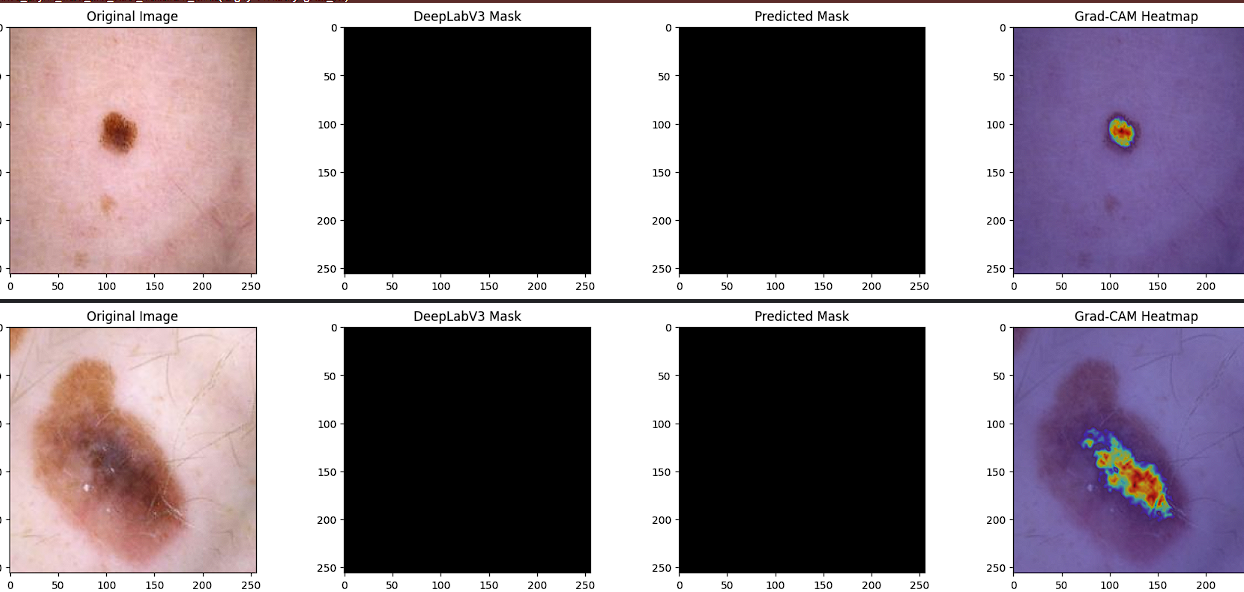

Starting training...
Epoch 1/5 - Loss: 0.6734 - Dice: 0.2289

Epoch 2/5 - Loss: 0.6674 - Dice: 0.2149

Epoch 3/5 - Loss: 0.6498 - Dice: 0.1712

Epoch 4/5 - Loss: 0.6321 - Dice: 0.2327

Epoch 5/5 - Loss: 0.5829 - Dice: 0.2057

Test Results (20 samples):
Dice Score: 0.4000
IoU: 0.4000!

In [ ]:
note the test was tested on kaggle for time concerns